In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler

In [2]:
## Test Data
fake_test_data = pd.read_csv('./Data/test.csv')

In [3]:
fake_test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
## create dataset
fake_news_df = pd.read_csv('./Data/train.csv')

In [5]:
fake_news_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
## Merge data for new column

fake_news_df["merged"] = fake_news_df["title"]+" "+fake_news_df["author"]

fake_news_df.head()

,id,title,author,text,label,merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [7]:
#  check null values
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
merged    2515
dtype: int64

In [8]:
# drop null values
fake_news_df=fake_news_df.dropna()

In [9]:
# Now count the Unique values using np.unique to find the elements of an array as parameter
count = np.unique(fake_news_df['label'], return_counts=True)
print(count)

(array([0, 1]), array([10361,  7924]))


<AxesSubplot:xlabel='label', ylabel='count'>

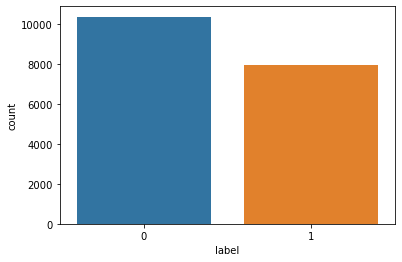

In [10]:
import seaborn as sns
sns.countplot(x='label', data = fake_news_df)

In [11]:
# Dependent Features
Y = fake_news_df['label']

# Independent Features
X = fake_news_df.drop('label', axis=1)

In [12]:
# change the dataset into numerical representation
# make the copy of Dependent Featues and reset the index because we drop the nan values due to this 
# the index is disturb
messages = X.copy()
# messages.reset_index(inplace=True)

In [13]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [14]:
messages.reset_index(inplace=True)

In [15]:
# Data processing
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataliakalugina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [17]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['merged'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [18]:
corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [19]:
voc_size = 5000
onehot_repre = [one_hot(words, voc_size) for words in corpus]
onehot_repre[0]

[3008, 3688, 4471, 3696, 3521, 4942, 2023, 157, 4646, 4513, 2142, 1158]

In [20]:
# Word embedding
sent_length = 20
embedded_docs = pad_sequences(onehot_repre, padding='pre', maxlen=sent_length)
print(embedded_docs[0])

[   0    0    0    0    0    0    0    0 3008 3688 4471 3696 3521 4942
 2023  157 4646 4513 2142 1158]


In [21]:
## CREATING A MODEL

In [22]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

2022-07-21 23:10:57.712780: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
x_final = np.array(embedded_docs)
y_final = np.array(Y)

In [24]:
x_final.shape, y_final.shape

((18285, 20), (18285,))

In [25]:
## SPLIT THE DATA INTO TRAIN AND TEST
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42)

In [26]:
# MODEL TRAINING
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)


Epoch 1/20
258/258 [==============================] - 6s 16ms/step - loss: 0.1923 - accuracy: 0.9173 - val_loss: 0.0321 - val_accuracy: 0.9874
Epoch 2/20
258/258 [==============================] - 3s 13ms/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.0221 - val_accuracy: 0.9929
Epoch 3/20
258/258 [==============================] - 3s 12ms/step - loss: 0.0092 - accuracy: 0.9978 - val_loss: 0.0176 - val_accuracy: 0.9934
Epoch 4/20
258/258 [==============================] - 4s 14ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0205 - val_accuracy: 0.9929
Epoch 5/20
258/258 [==============================] - 4s 14ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0190 - val_accuracy: 0.9929
Epoch 6/20
258/258 [==============================] - 3s 13ms/step - loss: 2.8397e-04 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9923
Epoch 7/20
258/258 [==============================] - 3s 13ms/step - loss: 1.0496e-04 - accuracy: 1.0000 - val_loss: 0.0263 - val_accuracy

In [27]:
# PERFORMANCE METRICS AND ACCURACY
classes_x = (model.predict(X_test) > 0.5).astype("int32")

58/58 [==============================] - 1s 3ms/step


In [28]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, classes_x)

array([[1033,    3],
       [  12,  781]])

In [29]:
#Accuracy Scores for multiple models
from sklearn.metrics import accuracy_score
score_0 = accuracy_score(y_test,classes_x)
print(score_0)

0.9917987971569163


In [30]:
# Model 1 is the Logistic Regression Model
model_1 = LogisticRegression(max_iter=900)
model_1.fit(X_train,y_train)
pred_1 = model_1.predict(X_test)

score_1 = accuracy_score(y_test,pred_1)
print(score_1)

0.7151448879168945


In [32]:
# Model 2 is Random Over Sampler
# Resample the training data with the RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

model_2 = RandomOverSampler(random_state=1)
X_resampled, y_resampled = model_2.fit_resample(X_train, y_train)
pred_2 = model.predict(X_test)

from sklearn.linear_model import LogisticRegression
model_2 = LogisticRegression(solver='lbfgs', random_state=1)
model_2.fit(X_resampled, y_resampled)

# Calculate the balanced accuracy score
pred_3 = model_2.predict(X_test)

from sklearn.metrics import balanced_accuracy_score
score_2 = balanced_accuracy_score(y_test,pred_3)
print(score_2)

58/58 [==============================] - 0s 4ms/step
0.7102013515947943


In [33]:
# Random Forest Classifier model
model_4 = RandomForestClassifier()
model_4.fit(X_train,y_train)
pred_4 = model_4.predict(X_test)
# cr4    = classification_report(y_test,pred_4)
# print(cr4)
score_4 = accuracy_score(y_test,pred_4)
print(score_4)

0.9043193001640241


In [34]:
from imblearn.under_sampling import ClusterCentroids

model_5 = ClusterCentroids(random_state=0)
X_resampled, y_resampled = model_5.fit_resample(X_train, y_train)

pred_5 = model_5.predict(X_test)
# cr5    = classification_report(y_test,pred_5)
# print(cr5)
score_5 = accuracy_score(y_test,pred_5)
print(score_5)

AttributeError: 'ClusterCentroids' object has no attribute 'predict'

In [ ]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN

sm = SMOTEENN(random_state=0)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

model_6 = LogisticRegression(solver='lbfgs', random_state=1)
model_6.fit(X_resampled, y_resampled)

pred_6 = model_6.predict(X_test)

from sklearn.metrics import balanced_accuracy_score
score_6 = balanced_accuracy_score(y_test,pred_6)
print(score_6)

In [38]:
model_7 = CatBoostClassifier(iterations=200)
X_resampled, y_resampled = model_7.fit(X_train, y_train)

model_7.fit(X_resampled, y_resampled)

pred_7 = model_7.predict(X_test)
# cr6    = classification_report(y_test,pred_6)
# print(cr6)
score_7 = balanced_accuracy_score(y_test,pred_6)
print(score_7)

Learning rate set to 0.149025
0:	learn: 0.6024878	total: 5.32ms	remaining: 1.06s
1:	learn: 0.5305078	total: 9.8ms	remaining: 970ms
2:	learn: 0.4845246	total: 14.6ms	remaining: 960ms
3:	learn: 0.4421794	total: 19.4ms	remaining: 951ms
4:	learn: 0.4209076	total: 23.8ms	remaining: 927ms
5:	learn: 0.4000616	total: 28.2ms	remaining: 911ms
6:	learn: 0.3865270	total: 32.3ms	remaining: 890ms
7:	learn: 0.3771853	total: 37.8ms	remaining: 906ms
8:	learn: 0.3622375	total: 41.8ms	remaining: 888ms
9:	learn: 0.3546364	total: 48.1ms	remaining: 914ms
10:	learn: 0.3465262	total: 52.9ms	remaining: 908ms
11:	learn: 0.3413523	total: 57.8ms	remaining: 906ms
12:	learn: 0.3335820	total: 62.6ms	remaining: 901ms
13:	learn: 0.3241545	total: 69.5ms	remaining: 923ms
14:	learn: 0.3207486	total: 74.8ms	remaining: 923ms
15:	learn: 0.3163325	total: 79.3ms	remaining: 912ms
16:	learn: 0.3080447	total: 83.7ms	remaining: 901ms
17:	learn: 0.3033320	total: 87.9ms	remaining: 889ms
18:	learn: 0.2983546	total: 92.1ms	remaining:

183:	learn: 0.0693756	total: 776ms	remaining: 67.4ms
184:	learn: 0.0688884	total: 781ms	remaining: 63.4ms
185:	learn: 0.0686400	total: 786ms	remaining: 59.1ms
186:	learn: 0.0684072	total: 791ms	remaining: 55ms
187:	learn: 0.0682819	total: 796ms	remaining: 50.8ms
188:	learn: 0.0680953	total: 800ms	remaining: 46.6ms
189:	learn: 0.0677608	total: 804ms	remaining: 42.3ms
190:	learn: 0.0674235	total: 809ms	remaining: 38.1ms
191:	learn: 0.0672531	total: 815ms	remaining: 34ms
192:	learn: 0.0667801	total: 820ms	remaining: 29.7ms
193:	learn: 0.0666157	total: 825ms	remaining: 25.5ms
194:	learn: 0.0663540	total: 830ms	remaining: 21.3ms
195:	learn: 0.0660633	total: 835ms	remaining: 17ms
196:	learn: 0.0658641	total: 840ms	remaining: 12.8ms
197:	learn: 0.0657317	total: 845ms	remaining: 8.53ms
198:	learn: 0.0656410	total: 850ms	remaining: 4.27ms
199:	learn: 0.0652232	total: 855ms	remaining: 0us


TypeError: cannot unpack non-iterable CatBoostClassifier object

In [42]:
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],
                       ["Random Forest",score_4],["LSTM",score_0]],columns=["Model","Accuracy"])

results

,Model,Accuracy
0,Logistic Regression,0.715145
1,Naive Bayes,0.710201
2,Random Forest,0.904319
3,LSTM,0.991799
